# Main Modelling Notebook

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

#### Load Data

In [52]:
# load data
%run -i data_loading.py

173805
79052
address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
interest_rate float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64
Indexes computed
19719
59333
PCA: first and last columns where % variance explained >= 99: [62 99]
PCA: first and last columns where % variance explained >= 85: Exception!


#### Set up Modelling Framework

In [57]:
# set up modelling framework
% run -i modelling_framework.py

#### Models without PCA

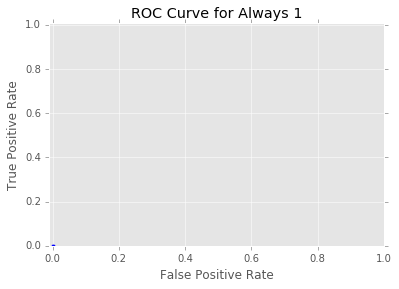

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [58]:
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0), model_name='Always 1')

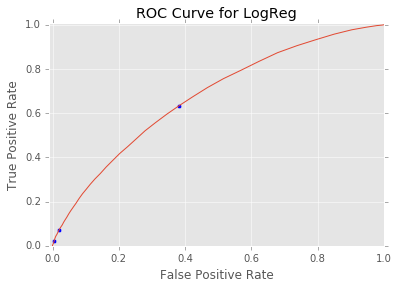

all   score: 0.844  baseline: 0.845   1-prec: 0.848   f1: 0.043  | test score 0.152  1-prec 0.851 f1 0.259  GP 840MM
2011  score: 0.886  baseline: 0.887   wscore: 0.888   f1: 0.035  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.014  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.824   f1: 0.098  | test score 0.822  1-prec 0.830


In [59]:
eval_model_by_year(lambda: Log_Reg(), model_name='LogReg')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), model_name='LogReg balanced')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, model_name='LogReg balanced .6')

In [ ]:
eval_model_by_year(lambda: QDA(reg_param = 1), model_name='QDA')

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), model_name='GBC')

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300), model_name='RFC 5/300')

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, class_weight = 'balanced', n_estimators=300),
                   model_name='RFC balanced 5/300')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                  model_name='DTC log2 balanced')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC sqrt balanced')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = None, class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC')

In [ ]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [ ]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

#### Other Models without PCA

In [ ]:
# TODO: Try again, this time fitting a regression against the payments received

In [ ]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

In [ ]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'], model_name='SmallBusiness')

In [ ]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [ ]:
lr_coeff.sort_values('abs', ascending=False).coeff

In [ ]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

In [ ]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [ ]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

In [ ]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [ ]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [ ]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                  x = x_expanded_pca, x_test = x_test_expanded_pca)

## NLP Modeling

#### Top Terms in Each Class

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: Log_Reg(C = 10 ** -6, class_weight = 'balanced'), 
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), prob_threshold = 0.6,
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: QDA(reg_param = 1), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300, class_weight = 'balanced'),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

#### Full Document-Term Matrix (Reduced with PCA)

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA Balanced')

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                   x = desc_matrix_pca, x_test = desc_matrix_test_pca,
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='GBC PCA')

## Stacking

In [ ]:
# function to create model stack
def create_model_stack(x_train, y_train):
    model_stack = []

    model_stack.append(Log_Reg(C = 10 ** -5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(LDA(shrinkage = 1, solver = 'lsqr').fit(x_train, y_train))
    model_stack.append(QDA(reg_param = 1).fit(x_train, y_train))
    model_stack.append(RFC(n_estimators = 300, max_depth = 5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1).fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', 
                           criterion = 'entropy').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = None, 
                           criterion = 'entropy').fit(x_train, y_train))
    #model_stack.append(SVC(class_weight = 'balanced').fit(x_train, y_train))
    
    return model_stack

In [ ]:
# function to fit and score a stacking ensemble
# TO DO: CV
def fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(model_stack)

    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))

    # predict with each model on training and testing data
    for index in range(num_models):
        model = model_stack[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # fit and predict with ensemble
    combiner.fit(y_train_stack, y_train)
    test_y_hat = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_train_stack, y_train)
    test_score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, test_y_hat)
    test_f1 = f1_score(y_test, test_y_hat, pos_label = 1)
    test_precision = 1 - y_test[test_y_hat].mean()
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    profit_mm = calc_expected_profit(profit_data_test, test_y_hat)

    return score, test_score, cm_df, test_f1, test_precision, profit_mm

In [ ]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(model_stack, x_train, y_train, x_test, y_test, combiner):

    score, test_score, cm_df, test_f1, test_precision, profit_mm = \
        fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner)

    print "%d  score: %.3f  baseline: %.3f   wscore: ----   f1: ----  | test score %.3f  1-prec %.3f f1 %.3f  GP %dMM" \
         % (0, score, 1 - y_train.mean(), test_score, test_precision, test_f1, profit_mm)

#### Regular Data

In [ ]:
model_stack = create_model_stack(x_expanded, y)

In [ ]:
combiner = Log_Reg(C = 10 ** -5, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

In [ ]:
combiner = RFC(class_weight = 'balanced')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

## Visualizations

In [ ]:
pd.DataFrame(model_performance).T

In [ ]:
model_performance_df = pd.DataFrame(model_performance).T
for col in model_performance_df.columns:
    model_performance_df[col].sort_values().plot(kind='barh')
    plt.title(col)
    plt.show()